# Spectrum simulation from a real observation



## Introduction

This notebook explains the use of the class SimulationRealBkg in gammapy.spectrum. 
This class is similar to the SpectrumSimulation class, but instead of using model backgrounds, uses real IRFs and a real sky background to simulate the observations; useful for understanding statisticaly effects in case of weak sources.

[TBD: do we merge the 2 classes or should this remain separate?]

## Setup - necessary imports...

In [1]:
import numpy as np
import os
import astropy
import sherpa
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.data import DataStore, ObservationList
from gammapy.data import ObservationStats, ObservationSummary
from gammapy.background.reflected import ReflectedRegionsBackgroundEstimator
from gammapy.utils.energy import EnergyBounds
from gammapy.spectrum import SpectrumExtraction, SpectrumObservation, SpectrumFit, SpectrumResult
from gammapy.spectrum import SimulationRealBkg
from gammapy.spectrum.models import PowerLaw



# Setup the logger



In [2]:
import logging
logging.basicConfig()
log = logging.getLogger('gammapy.spectrum')
log.setLevel(logging.ERROR)



## Choose the observations

We run our analysis using the standard 4 Crab observations at present. In practice, you should use this to simulate a spectrum from the sky region around your source.

In [3]:
data_store=DataStore.from_dir('$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2')
obsid=data_store.obs_table['OBS_ID'].data
print(obsid)



[23523 23526 23559 23592]


## Define your spectral model
Here we use a simple power law for demonstration

In [4]:
index = 2.1 * u.Unit('')
amplitude = 2.5 * 1e-10 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV
model = PowerLaw(index=index, amplitude=amplitude, reference=reference)



## Now run the simulation for the 4 observations. 
You have to pass the spectral model, the observation, and the source position (to calculate the offset) each time. We use SkyCoord from astropy to find the position of the source. You must be connected to the interent to be able to use this function.

The livetime for the simulation will be same as the observation livetime by default. You may also pass it as a parameter, "livetime=", to the class.

This class extracts the reflected background for each observation and creates an OFF PHA counts spectrum.

For each observation, we will simulate 10 spectra here (given by nsim)

#to be tested: 
Is it ok to pass the same seeds for each observation? Or should they be necessarily different like here. Since the seed acts as the obs id, will it affect the spectrum grouping/stacking later if it is the same?

In [5]:
name="Crab"
src=SkyCoord.from_name(name)
print(src)

<SkyCoord (ICRS): (ra, dec) in deg
    ( 83.633212,  22.01446)>


In [6]:
n_obs=len(obsid) # no. of observations 
nsim = 10 # no. of simulations per observation
mylist=data_store.obs_list(obsid)
seeds=np.arange(nsim*n_obs)
sims=[]
for i in range(n_obs):
    sim = SimulationRealBkg(source_model=model, obsrun=mylist[i], obspos=src)
    r1=nsim*i
    r2=r1+nsim
    sim.run(seeds[r1:r2])
    sims.extend(sim.result)
    #print sims
    



/Users/asinha/anaconda2/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)


Lets take a look at our first simulation

In [7]:
print(len(sims))
print(sims[0])

40
*** Observation summary report ***
Observation Id: 0
Livetime: 0.439 h
On events: 2560
Off events: 40
Alpha: 0.100
Bkg events in On region: 4.00
Excess: 2556.00
Excess / Background: 639.00
Gamma rate: 1.33 1 / min
Bkg rate: 0.00 1 / min
Sigma: 108.96
energy range: 0.02 TeV - 89.34 TeV


Now we take a look at the simulated counts and excess. 

('simulated source counts=', [2560, 2583, 2471, 2518, 2559, 2599, 2583, 2547, 2542, 2530, 2623, 2587, 2622, 2595, 2644, 2605, 2703, 2633, 2657, 2719, 1693, 1672, 1703, 1596, 1752, 1722, 1700, 1704, 1725, 1667, 1602, 1560, 1540, 1520, 1570, 1654, 1596, 1636, 1560, 1657])
('observed background counts=', [40, 40, 36, 33, 31, 28, 27, 23, 19, 18, 59, 49, 41, 40, 35, 33, 32, 28, 23, 20, 81, 78, 77, 77, 76, 75, 74, 74, 72, 71, 90, 88, 86, 82, 79, 69, 67, 66, 66, 65])
('predicted excess=', [2556.0, 2579.0, 2467.4000000000001, 2514.6999999999998, 2555.9000000000001, 2596.1999999999998, 2580.3000000000002, 2544.6999999999998, 2540.0999999999999, 2528.1999999999998, 2617.0999999999999, 2582.0999999999999, 2617.9000000000001, 2591.0, 2640.5, 2601.6999999999998, 2699.8000000000002, 2630.1999999999998, 2654.6999999999998, 2717.0, 1690.8684210526317, 1669.9473684210527, 1700.9736842105262, 1593.9736842105262, 1750.0, 1720.0263157894738, 1698.0526315789473, 1702.0526315789473, 1723.1052631578948, 1665

Text(0.5,0,u'excess')

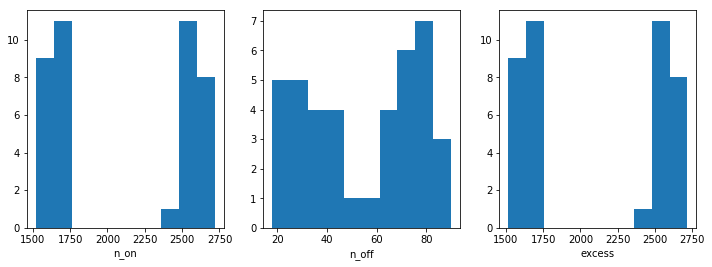

In [8]:
n_on = [obs.total_stats.n_on for obs in sims]
n_off = [obs.total_stats.n_off for obs in sims]
excess = [obs.total_stats.excess for obs in sims]
print("simulated source counts=", n_on)
print("observed background counts=", n_off)
print("predicted excess=", excess)
fix, axes = plt.subplots(1,3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel('n_on')
axes[1].hist(n_off)
axes[1].set_xlabel('n_off')
axes[2].hist(excess)
axes[2].set_xlabel('excess')


In [ ]:
best_fit_index = []
index_err=[]
best_fit_flux = []
flux_err=[]
for obs in sims:
    fit = SpectrumFit(obs, model=model, stat='wstat')
    fit.model.parameters['index'].value = 2.0
    fit.run()
    fit.est_errors()
    best_fit_index.append(fit.result[0].model.parameters['index'].value)
    best_fit_flux.append(fit.result[0].model.parameters['amplitude'].value)
    index_err.append(np.sqrt(fit.result[0].model.parameters.covariance[0][0]))
    flux_err.append(np.sqrt(fit.result[0].model.parameters.covariance[1][1]))

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:203: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:204: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))


In [ ]:

fix, axes = plt.subplots(1,2)
axes[0].hist(best_fit_index)
axes[0].set_xlabel('index')
axes[1].hist(best_fit_flux)
axes[1].set_xlabel('amplitude')



In [ ]:
plt.errorbar(best_fit_index,best_fit_flux,xerr=index_err,yerr=flux_err,fmt="ro")
plt.xlabel("Index")
plt.ylabel("Flux")

In [ ]:
print('best_fit_index:', best_fit_index)
print('best_fit_flux:', best_fit_flux)
